## Main routine for fitting release kinetic model to experimental concentration profiles in Figure 2.20 (A) and (B)

## Procedure outline:
1. Plot experimental data, i.e. concentration files
2. Fit of kinetic model
3. Plot experimental data together with model fit

Original author: [Hendrik Naatz](mailto:hendrik.naatz@arcelormittal.com)
Corresponding author: [Lutz Mädler](mailto:lmaedler@iwt.uni-bremen.de)

Current maintainer: [Stefan Endres](mailto:s.endres@iwt.uni-bremen.de)

Dependencies: `scipy`, `matplotlib`

In [12]:
# Library imports:
import numpy as np
import codecs, json
import copy
# Non std. library imports:
import scipy.io
import scipy.optimize
import matplotlib.pyplot as plt

# Module specific imports:
from dmcuo.load_settings import load_settings
from dmcuo.set_model_params import set_model_params
#from obj_fun import obj_fun
from dmcuo.reaction_kinetic_ODE_system import reaction_kinetic_ODE_system
from dmcuo.diffusion_controlled_release import diffusion_controlled_release
from dmcuo.obj_fun import obj_fun


# 1. Plot experimental data, i.e. concentration files

The first step in the workflow is to simply visualise the experimental concentration. The file stored in `dmcuo/Data/dissolution_profiles_cu2p.json` serves as a template using the data published in the accompanying paper. When modelling new chemical systems, the `data_path` variable below can point to another `.json` data file with new experimental data before proceding to Step 2.

In [13]:
# First load the data
data_path = 'dmcuo/Data/dissolution_profiles_cu2p.json'
opts, params, colors = load_settings()
## Load settings
# Note: N_Nodes should be 2500 for sufficient precision, see `load_settings.py` for additional options.
opts, params, colors = load_settings()

## Read in dissolution profiles, i.e. sampling times (time) in hours
# and dissolved Cu2+ species (c_cu2p) in mM, obtained via UV-Vis
# measurements according to [DOI: 10.1002/anie.201916183]
# load data from json:
obj_text = codecs.open(data_path, 'r', encoding='utf-8').read()
data = json.loads(obj_text)
print(f'data.keys() = {data.keys()}')
for d in data:
    data[d] = np.array(data[d])  # convert lists back to numpy arrays

#  Keys if the 4 data sets for labels
data_keys = ['CuO', 'CuO + 1% Fe', 'CuO + 6% Fe', 'CuO + 10% Fe']

data.keys() = dict_keys(['max', 'mean', 'min', 'time'])


In the next cell we plot the data, note that the experimental error bars are optional. If only one experiment was performed simply use a single value in the `mean` key and comment out the `yerror` and `ax.errorbar` lines:

<IPython.core.display.Javascript object>


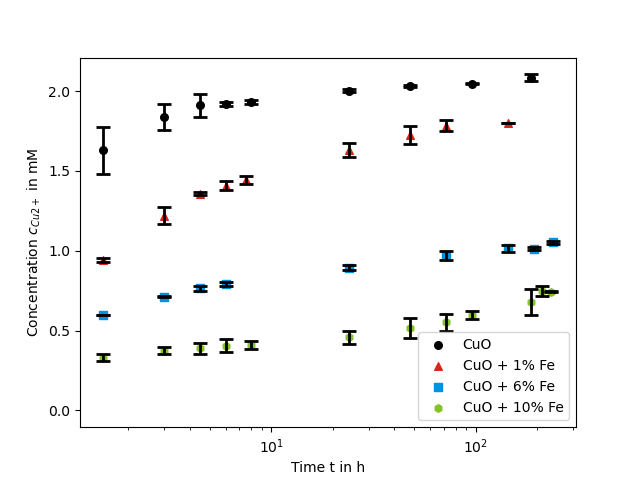

(13,)
0
1
2
3


In [14]:
%matplotlib notebook
## Plot experimental data (concentration profiles)
fig = plt.figure(1)
print(data['time'][0].shape)
markers = ['o', '^', 's', 'h']
ax = plt.gca()
for i in range(params.n_data):
    print(i)
    t = data['time'][i]
    y = data['mean'][i]
    ax.scatter(t, y, marker=markers[i], s=30, color=colors[i],
                label=data_keys[i])
    yerror = data['max'][i] - data['min'][i]
    ax.errorbar(t, y, yerr=yerror, ls='none', color='Black',
                 elinewidth=2, capthick=2, errorevery=1, alpha=1, ms=4, capsize=5
                 )
ax.set_xscale('log')
ax.set_xlabel('Time t in h'#, fontsize=28
              )
ax.set_ylabel(r'Concentration $c_{Cu2+}$ in mM'#, fontsize=28
              )
plt.legend()

# 2. Fit of kinetic model

Next we fit the parameteris of the kinetic model, it is essential to have good initial guess values, the guess values in the following cell worked well for the accompanying paper, new sytems might require new estimates. The boundaries of the optimisation routine should also be manually changed in the `set_model_params.py` file:

In [15]:
## Fit of kinetic model
# Initial guess of model parameters
k1 = 20  #% Dissolution rate constant for 0#% Fe
k2 = 4  #% Dissolution rate constant for 1#% Fe
k3 = 2.75  #% Dissolution rate constant for 6#% Fe
k4 = 1  #% Dissolution rate constant for 10#% Fe
ks = 1.25  #% Atomic surface concentration
D_solid = 0.00005  #% Diffusion coefficient
c1 = 2.25  # % C_CuO,0 inital concentration, always close to inital concentration given

#% Initial values
c2 = 0  #% C_Cu2+,0 initial concentration
c3 = 5  #% C_AminoAcid,0 initial concentration
c4 = 0  #% C_crystalization,0 initial concentration

# % Set initial model parameters and boundaries (currently fixed to optimized
# % value, these can be modified in `set_model_params.py` file:
params_0, params_lb, params_ub = set_model_params(k1, k2, k3, k4, ks, D_solid, c1, c2, c3, c4)
# % Number of fit parameters as defined in params_0
nvar = len(params_0)

Next we compute the model paramters regressed to the data (note that this cell might take several minutes to run):

In [ ]:
# % Definition of fit function (RMSE) to minimize in file obj_fun
obj_fun(params_0, data, params, opts, colors)
# % Fitting of model parameters with minimum root mean square error (params_f) using

# Compute the bounds sequence for the specified bounds:
bounds = []
for plb, pub in zip(params_lb, params_ub):
    bounds.append([plb, pub])
    
# Wrapper for the solver:
def obj(x,data, params, opts, colors):
    params_0 = x
    obj = obj_fun(params_0, data, params, opts, colors)
    return obj[0]

res = scipy.optimize.minimize(obj, params_0, args=(data, params, opts, colors))
print(f'rest = {res}')
params_f = res.x


data = {'max': array([[0.        , 1.70181741, 1.87717624, 1.94690033, 1.92696205,
        1.93631995, 2.00662173, 2.0336764 , 2.04885592, 2.09324263,
        0.        , 0.        , 0.        ],
       [0.        , 0.94805307, 1.24506986, 1.36054964, 1.42090827,
        1.4537595 , 1.65248135, 1.75257673, 1.79925364, 1.80149542,
        0.        , 0.        , 0.        ],
       [0.        , 0.59736974, 0.71563394, 0.77280676, 0.79713864,
        0.90279962, 0.98148399, 1.025954  , 1.01772368, 1.05651056,
        0.        , 0.        , 0.        ],
       [0.        , 0.34044858, 0.38457369, 0.40459676, 0.42601389,
        0.41986828, 0.47828531, 0.5460153 , 0.57802178, 0.60816787,
        0.72061349, 0.76472437, 0.74335344]]), 'mean': array([[0.        , 1.62860165, 1.83684412, 1.91019723, 1.91966707,
        1.93097585, 2.00204807, 2.02989875, 2.04653074, 2.08234468,
        0.        , 0.        , 0.        ],
       [0.        , 0.94217662, 1.2190105 , 1.35575389, 1.40794332,
  

/usr/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:46: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))
/home/endres/iwt-projects/naatz/DissolutionModelCuO/dmcuo/dmcuo/radial_diffusion_PDE.py:31: RuntimeWarning: divide by zero encountered in double_scalars
  
/usr/lib/python3.10/site-packages/scipy/integrate/_ode.py:1350: UserWarning: lsoda: Excess accuracy requested (tolerances too small).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.0000000000000D+00   r2 =  0.0000000000000D+00
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.0000000000000D+00   r2 =  0.0000000000000D+00
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.0000000000000D+00   r2 =  0.0000000000000D+00
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.0000000000000D+00   r2 =  0.0000000000000D+00
 lsoda--  warning..internal t (=r1) 

sol2.y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
sol2.t = [0.]
data = {'max': array([[0.        , 1.70181741, 1.87717624, 1.94690033, 1.92696205,
        1.93631995, 2.00662173, 2.0336764 , 2.04885592, 2.09324263,
        0.        , 0.        , 0.        ],
       [0.        , 0.94805307, 1.24506986, 1.36054964, 1.42090827,
        1.4537595 , 1.65248135, 1.75257673, 1.79925364, 1.80149542,
        0.        , 0.        , 0.        ],
       [0.        , 0.59736974, 0.71563394, 0.77280676, 0.79713864,
        0.90279962, 0.98148399, 1.025954  , 1.01772368, 1.05651056,
        0.        , 0.        , 0.        ],
       [0.        , 0.34044858, 0.38457369, 0.40459676, 0.42601389,
        0.41986828, 0.47828531, 0.5460153 , 0.57802178, 0.60816787,
        0.72061349, 0.76472437, 0.74335344]]), 'mean': array([[0.        , 1.62860165, 1.83684412, 1.91019723, 1.91966707,
        1.93097585, 2.00204807, 2.02989875, 2.04653074, 2.08234468,
        0.        , 0.        , 0.        ],
      

sol2.y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
sol2.t = [0.]
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.0000000000000D+00   r2 =  0.0000000000000D+00
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.0000000000000D+00   r2 =  0.0000000000000D+00
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.0000000000000D+00   r2 =  0.0000000000000D+00
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.0000000000000D+00   r2 =  0

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.0000000000000D+00   r2 =  0.0000000000000D+00
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.0000000000000D+00   r2 =  0.0000000000000D+00
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.0000000000000D+00   r2 =  0.0000000000000D+00
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.0000000000000D+00   r2 =  0.0000000000000D+00
 lsoda--  warning..internal t (=r1) 

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.0000000000000D+00   r2 =  0.0000000000000D+00
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.0000000000000D+00   r2 =  0.0000000000000D+00
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.0000000000000D+00   r2 =  0.0000000000000D+00
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.0000000000000D+00   r2 =  0.0000000000000D+00
 lsoda--  warning..internal t (=r1) 

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.0000000000000D+00   r2 =                  NaN
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.0000000000000D+00   r2 =  0.0000000000000D+00
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.0000000000000D+00   r2 =  0.0000000000000D+00
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.0000000000000D+00   r2 =  0.0000000000000D+00
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t o

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.0000000000000D+00   r2 =  0.0000000000000D+00
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.0000000000000D+00   r2 =  0.0000000000000D+00
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.0000000000000D+00   r2 =  0.0000000000000D+00
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.0000000000000D+00   r2 =  0.0000000000000D+00
 lsoda--  warning..internal t (=r1) 

sol2.y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
sol2.t = [0.]
data = {'max': array([[0.        , 1.70181741, 1.87717624, 1.94690033, 1.92696205,
        1.93631995, 2.00662173, 2.0336764 , 2.04885592, 2.09324263,
        0.        , 0.        , 0.        ],
       [0.        , 0.94805307, 1.24506986, 1.36054964, 1.42090827,
        1.4537595 , 1.65248135, 1.75257673, 1.79925364, 1.80149542,
        0.        , 0.        , 0.        ],
       [0.        , 0.59736974, 0.71563394, 0.77280676, 0.79713864,
        0.90279962, 0.98148399, 1.025954  , 1.01772368, 1.05651056,
        0.        , 0.        , 0.        ],
       [0.        , 0.34044858, 0.38457369, 0.40459676, 0.42601389,
        0.41986828, 0.47828531, 0.5460153 , 0.57802178, 0.60816787,
        0.72061349, 0.76472437, 0.74335344]]), 'mean': array([[0.        , 1.62860165, 1.83684412, 1.91019723, 1.91966707,
        1.93097585, 2.00204807, 2.02989875, 2.04653074, 2.08234468,
        0.        , 0.        , 0.        ],
      

       (h = step size). solver will sol2.y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
sol2.t = [0.]
continue anyway  
      in above,  r1 =  0.0000000000000D+00   r2 =  0.0000000000000D+00
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.0000000000000D+00   r2 =  0.0000000000000D+00
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.0000000000000D+00   r2 =  0.0000000000000D+00
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.0000000000000D+00   r2 =  0.0000000000000D+00
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t 

sol2.y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.0000000000000D+00   r2 =  0.0000000000000D+00
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.0000000000000D+00   r2 =  0.0000000000000D+00
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.0000000000000D+00   r2 =  0.0000000000000D+00
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.0000000000000D+00   r2 =  0.0000000000000D

sol2.y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
sol2.t = [0.]
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.0000000000000D+00   r2 =                  NaN
sol2.y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
sol2.t = [0.]
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.0000000000000D+00   r2 =  0.0000000000000D+00
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.0000000000000D+00   r2 =  0.0000000000000D+00
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.0000000000000D+00   r2 =  0.000000

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.0000000000000D+00   r2 =  0.0000000000000D+00
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.0000000000000D+00   r2 =  0.0000000000000D+00
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.0000000000000D+00   r2 =  0.0000000000000D+00
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.0000000000000D+00   r2 =  0.0000000000000D+00
 lsoda--  warning..internal t (=r1) 

sol2.y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
sol2.t = [0.]
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.0000000000000D+00   r2 =  0.0000000000000D+00
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.0000000000000D+00   r2 =  0.0000000000000D+00
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.0000000000000D+00   r2 =  0.0000000000000D+00
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.0000000000000D+00 

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
sol2.y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
sol2.t = [0.]
      in above,  r1 =  0.0000000000000D+00   r2 =  0.0000000000000D+00
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.0000000000000D+00   r2 =  0.0000000000000D+00
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.0000000000000D+00   r2 =  0.0000000000000D+00
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.0000000000000D+00   r2 =  0

sol2.y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
sol2.t = [0.]
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.0000000000000D+00   r2 =  0.0000000000000D+00
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.0000000000000D+00   r2 =  0.0000000000000D+00
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.0000000000000D+00   r2 =  0.0000000000000D+00
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.0000000000000D+00   r2 =  0

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.0000000000000D+00   r2 =  0.0000000000000D+00
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.0000000000000D+00   r2 =  0.0000000000000D+00
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.0000000000000D+00   r2 =  0.0000000000000D+00
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.0000000000000D+00   r2 =  0.0000000000000D+00
 lsoda--  warning..internal t (=r1) 

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.0000000000000D+00   r2 =  0.0000000000000D+00
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.0000000000000D+00   r2 =  0.0000000000000D+00
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.0000000000000D+00   r2 =  0.0000000000000D+00
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.0000000000000D+00   r2 =  0.0000000000000D+00
 lsoda--  warning..internal t (=r1) 

       (h = step size). solver will continue anyway  
      in above,  r1 =  0.0000000000000D+00   r2 =  0.0000000000000D+00
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.0000000000000D+00   r2 =  0.0000000000000D+00
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.0000000000000D+00   r2 =  0.0000000000000D+00
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.0000000000000D+00   r2 =  0.0000000000000D+00
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will 

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.0000000000000D+00   r2 =  0.0000000000000D+00
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.0000000000000D+00   r2 =  0.0000000000000D+00
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.0000000000000D+00   r2 =  0.0000000000000D+00
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.0000000000000D+00   r2 =  0.0000000000000D+00
 lsoda--  warning..internal t (=r1) 

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.0000000000000D+00   r2 =  0.0000000000000D+00
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.0000000000000D+00   r2 =  0.0000000000000D+00
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.0000000000000D+00   r2 =  0.0000000000000D+00
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.0000000000000D+00   r2 =  0.0000000000000D+00
 lsoda--  warning..internal t (=r1) 

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.0000000000000D+00   r2 =  0.0000000000000D+00
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.0000000000000D+00   r2 =  0.0000000000000D+00
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.0000000000000D+00   r2 =  0.0000000000000D+00
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.0000000000000D+00   r2 =  0.0000000000000D+00
 lsoda--  warning..internal t (=r1) 

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.0000000000000D+00   r2 =  0.0000000000000D+00
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.0000000000000D+00   r2 =  0.0000000000000D+00
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.0000000000000D+00   r2 =  0.0000000000000D+00
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.0000000000000D+00   r2 =  0.0000000000000D+00
 lsoda--  warning..internal t (=r1) 

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.0000000000000D+00   r2 =                  NaN
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.0000000000000D+00   r2 =  0.0000000000000D+00
sol2.y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
sol2.t = [0.]
data = {'max': array([[0.        , 1.70181741, 1.87717624, 1.94690033, 1.92696205,
        1.93631995, 2.00662173, 2.0336764 , 2.04885592, 2.09324263,
        0.        , 0.        , 0.        ],
       [0.        , 0.94805307, 1.24506986, 1.36054964, 1.42090827,
        1.4537595 , 1.65248135, 1.75257673, 1.79925364, 1.80149542,
        0.        , 0.        , 0.        ],
       [0.        , 0.59736974, 0.71563394, 0.77280676, 0.79713864,
        0.90279962, 0.98148399, 1.025954  , 1.01772368, 1.05651056,
   

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.0000000000000D+00   r2 =  0.0000000000000D+00
sol2.y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
sol2.t = [0.]
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.0000000000000D+00   r2 =  0.0000000000000D+00
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.0000000000000D+00   r2 =  0.0000000000000D+00
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.0000000000000D+00   r2 =  0

/home/endres/iwt-projects/naatz/DissolutionModelCuO/dmcuo/dmcuo/reaction_kinetic_ODE_system.py:11: RuntimeWarning: invalid value encountered in double_scalars
  dcdt[1-1] = -k[l] * (1/k[5] * (c[8-1]/(c[7-1] + c[8-1])) * c[5-1]) ** (m/2) * c[3-1] ** (n/2)
/home/endres/iwt-projects/naatz/DissolutionModelCuO/dmcuo/dmcuo/reaction_kinetic_ODE_system.py:13: RuntimeWarning: invalid value encountered in double_scalars
  dcdt[2-1] = k[l] * (1/k[5] * (c[8-1]/(c[7-1] + c[8-1])) * c[5-1]) ** (m/2) * c[3-1] ** (n/2)
/home/endres/iwt-projects/naatz/DissolutionModelCuO/dmcuo/dmcuo/reaction_kinetic_ODE_system.py:15: RuntimeWarning: invalid value encountered in double_scalars
  dcdt[3-1] = -2 * k[l] * (1/k[5] * (c[8-1]/(c[7-1] + c[8-1])) * c[5-1]) ** (m/2) * c[3-1] ** (n/2)
/home/endres/iwt-projects/naatz/DissolutionModelCuO/dmcuo/dmcuo/reaction_kinetic_ODE_system.py:17: RuntimeWarning: invalid value encountered in double_scalars
  dcdt[4-1] = -k[l]/c[5-1] * (1/k[5] * (c[8-1]/(c[7-1] + c[8-1])) * c[5-1

# 3. Plot experimental data together with model fit

Finally we plot the model with the fitted parameters and compare the resutls to the experimental data. 

In [ ]:
# First we 
tSpan = np.linspace(0, data['time'][-1][-1], 3000)
print(f" data['time'] = { data['time']}")

tl = data['time'].shape[0]
data_time = copy.copy(data['time'])  # temporary variable
data['time'] = []
for l in range(tl):
    data['time'].append(tSpan)
    
# Now we can compute the model output using the model contained in `obj_fun`: 
[minSquareError, model, sol2] = obj_fun(params_f, data, params, opts, colors)

# 
data['time'] = data_time


<IPython.core.display.Javascript object>


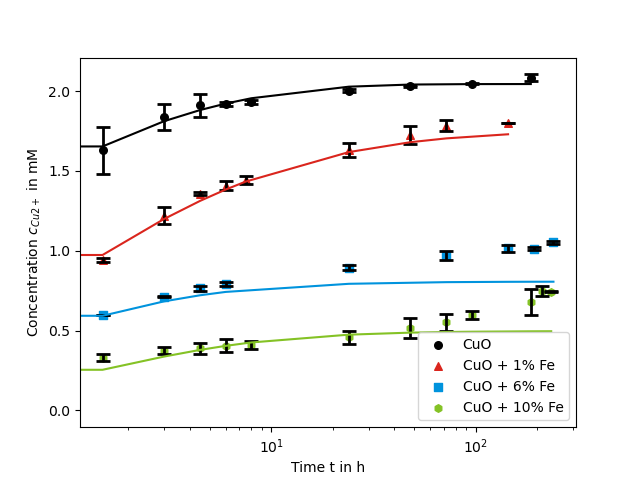

colors = [array([0., 0., 0.]), array([0.85490196, 0.14509804, 0.11372549]), array([0.        , 0.57647059, 0.86666667]), array([0.51764706, 0.76078431, 0.14509804])]
(13,)
0
model = {'t': [array([  0. ,   1.5,   3. ,   4.5,   6. ,   8. ,  24. ,  48. ,  96. ,
       186. ]), array([  0. ,   1.5,   3. ,   4.5,   6. ,   7.5,  24. ,  48. ,  72. ,
       144. ]), array([  0. ,   1.5,   3. ,   4.5,   6. ,  24. ,  72. , 144. , 192. ,
       240. ]), array([  0. ,   1.5,   3. ,   4.5,   6. ,   8. ,  24. ,  48. ,  72. ,
        96. , 186. , 210. , 234. ])], 'c_cu2p_1': [array([[2.04372585e+00, 3.90674069e-01, 2.32599882e-01, 1.62748261e-01,
        1.22342574e-01, 8.89540933e-02, 1.64736619e-02, 3.10086619e-03,
        3.04426723e-04, 1.82278870e-05],
       [0.00000000e+00, 1.65305178e+00, 1.81112596e+00, 1.88097758e+00,
        1.92138327e+00, 1.95477175e+00, 2.02725218e+00, 2.04062498e+00,
        2.04342142e+00, 2.04370762e+00],
       [5.00000000e+00, 1.69389645e+00, 1.37774807e+00, 1.2380

In [19]:
fig = plt.figure(2)
markers = ['o', '^', 's', 'h']
ax = plt.gca()
for i in range(params.n_data):
    t = data['time'][i]
    y = data['mean'][i]
    ax.scatter(t, y, marker=markers[i], s=30, color=colors[i],
               label=data_keys[i])
    yerror = data['max'][i] - data['min'][i]
    ax.errorbar(t, y, yerr=yerror, ls='none', color='Black',
                elinewidth=2, capthick=2, errorevery=1, alpha=1, ms=4, capsize=5
                )
    # plot(model.t{i},model.c_cu2p_1{i}(2,:)+model.c_cu2p_2{i}(end,:),'k-')
   # ax.plot(model['t'][i], model['c_cu2p_1'][i][2-1] + model['c_cu2p_2'][i][-1])
    ax.plot(model['t'][i], model['c_cu2p_1'][i][2-1], color=colors[i])
ax.set_xscale('log')
ax.set_xlabel('Time t in h'  # , fontsize=28
              )
ax.set_ylabel(r'Concentration $c_{Cu2+}$ in mM'  # , fontsize=28
              )
plt.legend()
